Episode 0: steps=56, reward=-112.3, avg100=-112.3, alpha~(policy) see last=1.18
Regret summary: mean=81.49, max=114.36
Example decision process:
ACTION: Fire right (p=0.24, α=1.18)
STATE: moving left (vx=-0.8), falling (vy=-0.5)
REASONING: Adjusting trajectory rightward
FUZZY MEMBERSHIPS: Do nothing=0.58 Fire left=0.43 Fire main=0.20 Fire right=0.79 
--------------------------------------------------------------------------------
Episode 1: steps=91, reward=-212.7, avg100=-162.5, alpha~(policy) see last=1.18
Regret summary: mean=81.71, max=164.11
Example decision process:
ACTION: Fire left (p=0.36, α=1.18)
STATE: stable flight
REASONING: Adjusting trajectory leftward
FUZZY MEMBERSHIPS: Do nothing=0.70 Fire left=0.45 Fire main=0.18 Fire right=0.71 
--------------------------------------------------------------------------------
Episode 2: steps=53, reward=-91.1, avg100=-138.7, alpha~(policy) see last=1.18
Regret summary: mean=68.39, max=164.11
Example decision process:
ACTION: Fire main

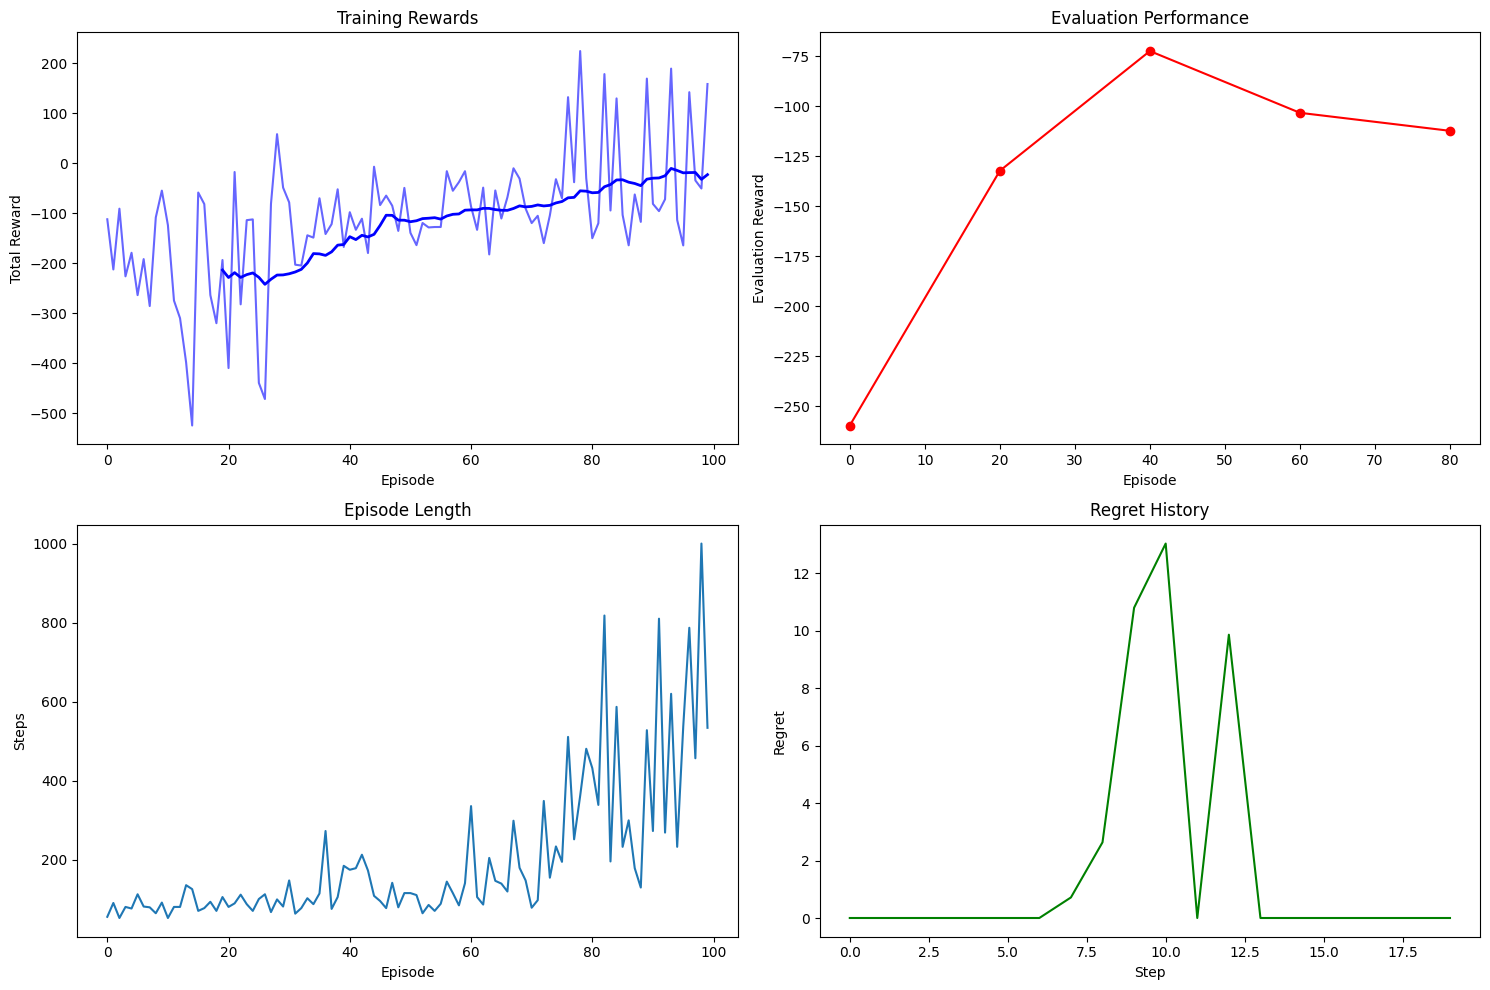

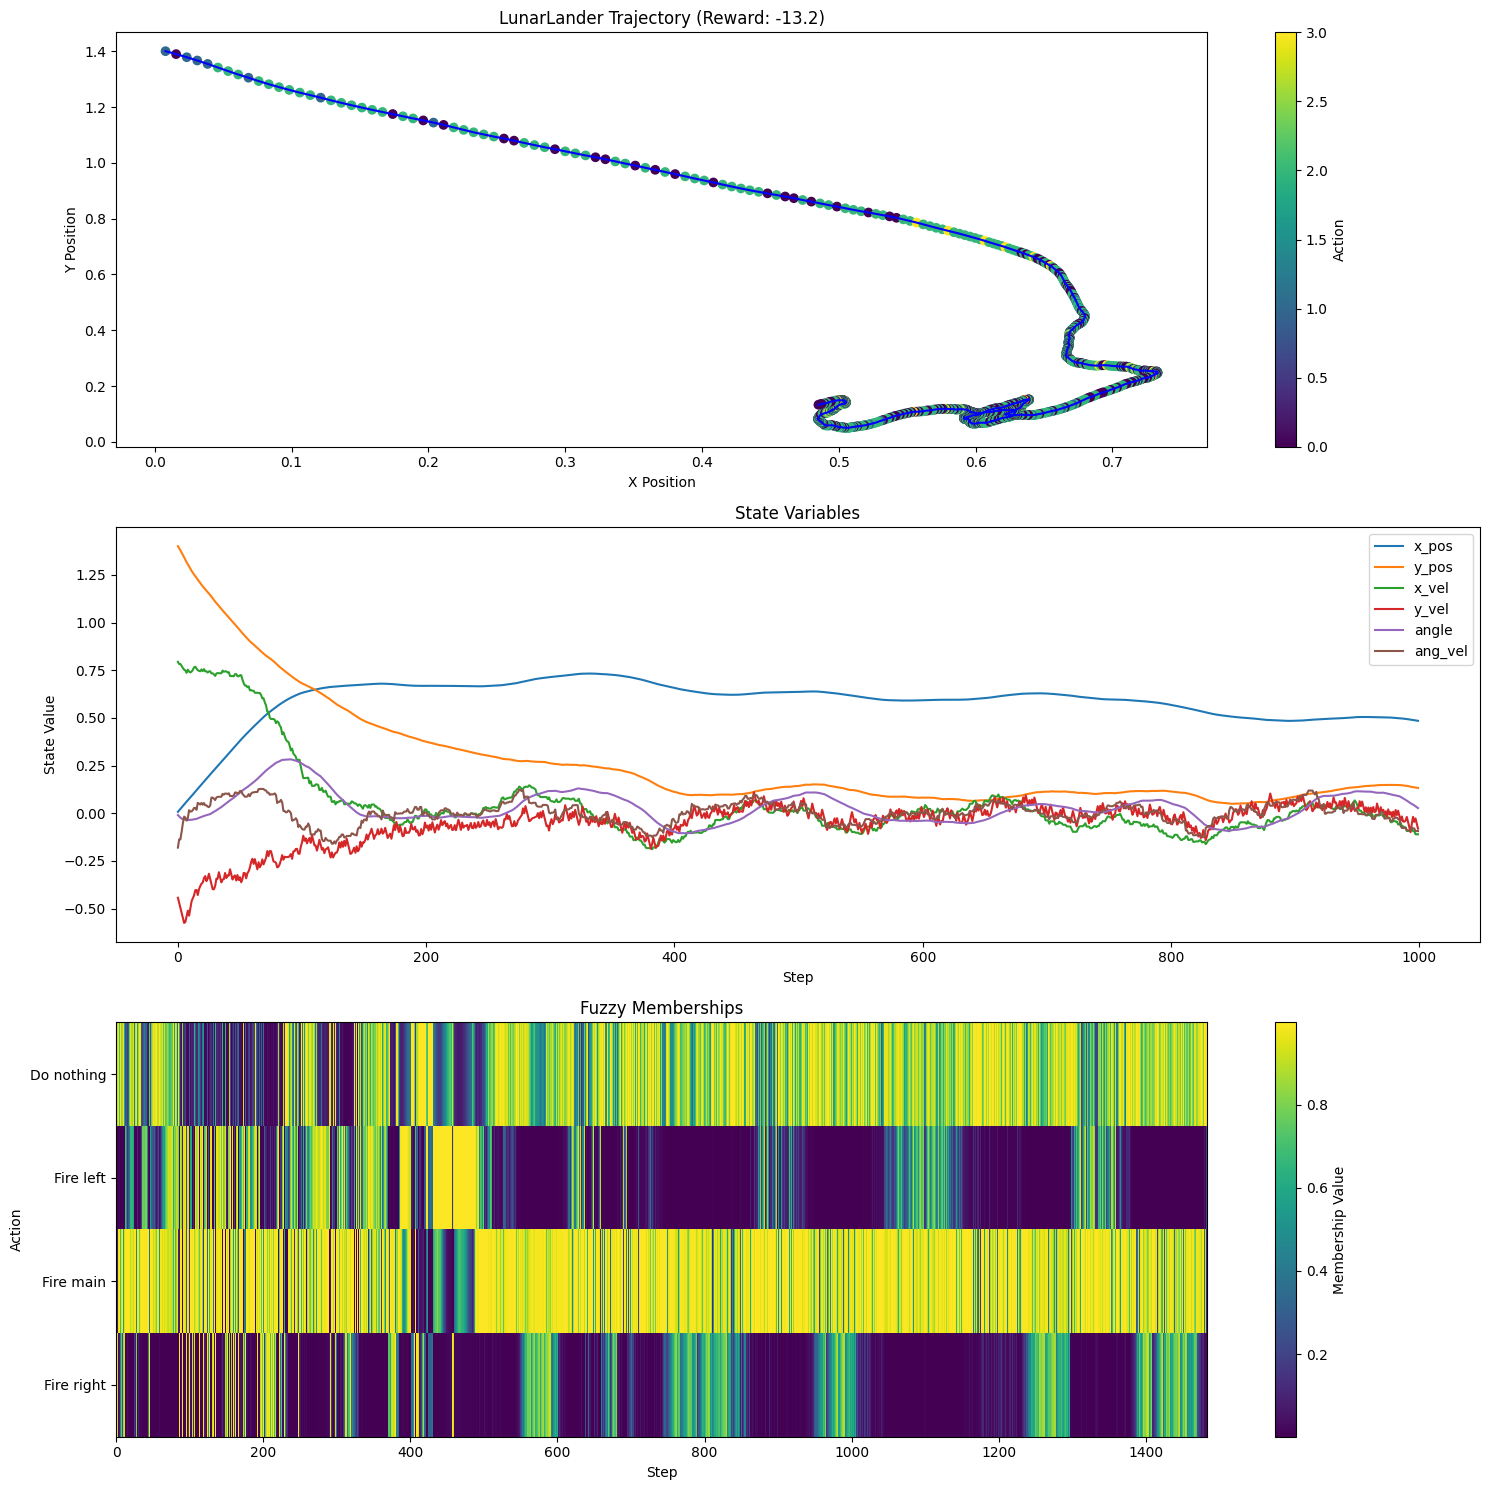

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from typing import Tuple, List, Dict, Optional, Any
import gymnasium as gym
from collections import deque
import random
import time

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# ------------------------------
# 1. Enhanced FuzzyWavePolicy with Sigmoid Activations
# ------------------------------
class FuzzyWavePolicy(nn.Module):
    def __init__(self, state_dim: int, action_dim: int, hidden_dim: int = 256, 
                 dynamic_alpha: bool = True, adaptive_capacity: bool = True):
        super().__init__()
        self.dynamic_alpha = dynamic_alpha
        self.adaptive_capacity = adaptive_capacity
        self.action_dim = action_dim
        
        # Main policy network (backbone)
        self.backbone = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        
        # Membership function head
        self.membership_head = nn.Sequential(
            nn.Linear(hidden_dim, action_dim),
            nn.LayerNorm(action_dim),
            nn.Sigmoid()  # ensures values in [0,1]
        )
        nn.init.xavier_normal_(self.membership_head[0].weight, gain=0.5)
        
        # Value function
        self.value_head = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        
        # Dynamic alpha network (regret-aware temperature parameter)
        if dynamic_alpha:
            self.alpha_net = nn.Sequential(
                nn.Linear(hidden_dim, 32),
                nn.ReLU(),
                nn.Linear(32, 1),
                nn.Softplus()  # ensures alpha > 0
            )
            # Initialize alpha_net to moderate values
            self.alpha_net[2].weight.data.fill_(0.005)
            self.alpha_net[2].bias.data.fill_(0.5)
        else:
            self.alpha_net = None
        
        # Adaptive capacity
        if adaptive_capacity:
            self.regret_gates = nn.Parameter(torch.ones(hidden_dim) * -2.0)
            self.adaptive_layer = nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.LayerNorm(hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, hidden_dim),
                nn.LayerNorm(hidden_dim)
            )
            for m in self.adaptive_layer.modules():
                if isinstance(m, nn.Linear):
                    nn.init.xavier_normal_(m.weight, gain=0.1)
        
        self.to(device)
    
    def forward(self, state: torch.Tensor) -> Dict[str, torch.Tensor]:
        features = self.backbone(state)
        
        # Adaptive capacity
        if self.adaptive_capacity:
            gates = torch.sigmoid(self.regret_gates) * 0.2
            adaptive_features = self.adaptive_layer(features)
            features = features + gates * adaptive_features
        
        # Fuzzy memberships
        memberships = self.membership_head(features)
        
        # State-dependent alpha if enabled
        if self.dynamic_alpha and self.alpha_net is not None:
            raw_alpha = self.alpha_net(features) + 0.2
            alpha = torch.clamp(raw_alpha, min=0.1, max=10.00)
        else:
            alpha = torch.ones(state.size(0), 1, device=device)
        
        value = self.value_head(features)
            
        return {
            'memberships': memberships,
            'alpha': alpha,
            'value': value,
            'features': features
        }

# ------------------------------
# 2. Learned Dynamics Model
# ------------------------------
class DynamicsModel(nn.Module):
    """Learned dynamics model for counterfactual reflection."""
    def __init__(self, state_dim: int, action_dim: int, hidden_dim: int = 256):
        super().__init__()
        
        self.action_embedding = nn.Embedding(action_dim, 16)
        self.model = nn.Sequential(
            nn.Linear(state_dim + 16, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, state_dim + 1)
        )
        for m in self.model.modules():
            if isinstance(m, nn.Linear):
                nn.init.orthogonal_(m.weight, gain=1.0)
                nn.init.constant_(m.bias, 0.0)
        
        self.uncertainty_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Linear(hidden_dim//2, state_dim),
            nn.Softplus()
        )
        self.recent_errors = deque(maxlen=1000)
    
    def forward(self, state: torch.Tensor, action: torch.Tensor) -> Dict[str, torch.Tensor]:
        action_emb = self.action_embedding(action)
        x = torch.cat([state, action_emb], dim=-1)
        
        # We want features for the uncertainty head
        # We'll do a manual forward to capture intermediate features
        hidden = x
        for i, layer in enumerate(self.model):
            hidden = layer(hidden)
            if i == 2:  # after the second layer
                mid_features = hidden
        
        next_state = hidden[:, :-1]
        reward = hidden[:, -1:]
        
        uncertainty = self.uncertainty_head(mid_features)
        return {
            'next_state': next_state,
            'reward': reward,
            'uncertainty': uncertainty
        }
    
    def update(self, states, actions, next_states, rewards):
        if isinstance(states, np.ndarray):
            states = torch.FloatTensor(states).to(device)
            next_states = torch.FloatTensor(next_states).to(device)
            rewards = torch.FloatTensor(rewards).to(device)
        if isinstance(actions, list) or isinstance(actions, np.ndarray):
            actions = torch.LongTensor(actions).to(device)
        if states.dim() == 1:
            states = states.unsqueeze(0)
            actions = actions.unsqueeze(0)
            next_states = next_states.unsqueeze(0)
            rewards = rewards.unsqueeze(0)
        
        pred = self(states, actions)
        pred_next_states = pred['next_state']
        pred_rewards = pred['reward']
        uncertainty = pred['uncertainty']
        
        state_diff = next_states - pred_next_states
        # Weighted by uncertainty
        state_loss_term = 0.5 * torch.exp(-uncertainty) * (state_diff ** 2) + 0.5 * uncertainty
        state_loss = state_loss_term.mean()
        reward_loss = F.mse_loss(pred_rewards, rewards.unsqueeze(-1))
        loss = state_loss + reward_loss
        
        with torch.no_grad():
            mse = F.mse_loss(pred_next_states, next_states)
            self.recent_errors.append(mse.item())
        
        return loss
    
    def get_average_error(self):
        if not self.recent_errors:
            return float('inf')
        return sum(self.recent_errors) / len(self.recent_errors)
    
    def predict_trajectory(self, initial_state, actions, max_steps=100):
        states = [initial_state]
        rewards = []
        uncertainties = []
        
        state = torch.FloatTensor(initial_state).unsqueeze(0).to(device)
        for i, action in enumerate(actions):
            if i >= max_steps:
                break
            action_tensor = torch.LongTensor([action]).to(device)
            pred = self(state, action_tensor)
            next_state = pred['next_state'].squeeze(0).detach().numpy()
            reward = pred['reward'].item()
            uncertainty = pred['uncertainty'].mean().item()
            
            states.append(next_state)
            rewards.append(reward)
            uncertainties.append(uncertainty)
            state = pred['next_state']
        
        return states, rewards, uncertainties


# ------------------------------
# 3. Regret Analysis Module
# ------------------------------
class RegretAnalysisModule:
    def __init__(self, state_dim, action_dim, memory_size=10000):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.high_regret_memory = deque(maxlen=memory_size)
        self.regret_patterns = {}
        self.regret_threshold = 1.0
        self.recent_regrets = deque(maxlen=100)
        self.state_regret_correlation = np.zeros(state_dim)
    
    def add_experience(self, state, action, alt_action, regret, state_key=None):
        if regret > self.regret_threshold:
            self.high_regret_memory.append({
                'state': state,
                'action': action,
                'alt_action': alt_action,
                'regret': regret
            })
        self.recent_regrets.append(regret)
        
        # Update threshold
        if len(self.recent_regrets) >= 20:
            self.regret_threshold = np.percentile(list(self.recent_regrets), 80)
        
        if regret > 0:
            for i in range(self.state_dim):
                normalized_state = 2 * (abs(state[i]) - 0.5)
                if normalized_state > 0:
                    self.state_regret_correlation[i] += normalized_state * regret
        
        if state_key is not None:
            if state_key not in self.regret_patterns:
                self.regret_patterns[state_key] = []
            self.regret_patterns[state_key].append(regret)
    
    def get_adaptive_network_parameters(self):
        if np.sum(np.abs(self.state_regret_correlation)) > 0:
            state_attention = self.state_regret_correlation / np.sum(np.abs(self.state_regret_correlation))
        else:
            state_attention = np.ones(self.state_dim) / self.state_dim
            
        regret_importance = min(len(self.high_regret_memory) / 100, 1.0)
        regret_gates = regret_importance * np.ones(256)
            
        return {
            'state_attention': state_attention,
            'regret_gates': regret_gates
        }
    
    def get_regret_summary(self):
        mean_regret = np.mean(list(self.recent_regrets)) if self.recent_regrets else 0
        max_regret = np.max(list(self.recent_regrets)) if self.recent_regrets else 0
        return {
            'mean_regret': mean_regret,
            'max_regret': max_regret,
            'threshold': self.regret_threshold,
            'high_regret_count': len(self.high_regret_memory),
            'state_attention': self.state_regret_correlation
        }


# ------------------------------
# 4. Fuzzy-Wave Agent with Regret Awareness
# ------------------------------

class RegretAwareFuzzyAgent:
    def __init__(self, state_dim: int, action_dim: int, 
                 lr: float = 5e-4, gamma: float = 0.99, entropy_coef: float = 0.01,
                 dynamics_lr: float = 1e-3,
                 regret_short_term_factor: float = 0.05,
                 regret_long_term_factor: float = 0.005):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.entropy_coef = entropy_coef
        self.regret_short_term_factor = regret_short_term_factor
        self.regret_long_term_factor = regret_long_term_factor
        
        # Policy with dynamic alpha
        self.policy = FuzzyWavePolicy(
            state_dim, action_dim, 
            dynamic_alpha=True, 
            adaptive_capacity=True
        ).to(device)
        
        # Learned dynamics for counterfactuals
        self.dynamics_model = DynamicsModel(state_dim, action_dim).to(device)
        
        # Regret analysis
        self.regret_module = RegretAnalysisModule(state_dim, action_dim)
        
        # Policy optimizer
        membership_params = list(self.policy.membership_head.parameters())
        alpha_params = list(self.policy.alpha_net.parameters()) if self.policy.dynamic_alpha else []
        other_params = [p for p in self.policy.parameters() 
                        if not any(p is mp for mp in membership_params + alpha_params)]
        
        self.policy_optimizer = optim.Adam([
            {'params': membership_params, 'lr': lr * 0.5}, 
            {'params': alpha_params, 'lr': lr * 0.3},
            {'params': other_params, 'lr': lr}
        ])
        self.dynamics_optimizer = optim.Adam(self.dynamics_model.parameters(), lr=dynamics_lr)
        
        # Experience replay
        self.buffer = ReplayBuffer(capacity=100000)
        
        # Logging
        self.membership_history = []
        self.alpha_history = []
        self.regret_history = []
        self.value_history = []
        self.action_history = []
        self.reward_history = []
    
    def select_action(self, state, deterministic=True, store_history=True):
        if isinstance(state, np.ndarray):
            state_t = torch.FloatTensor(state).unsqueeze(0).to(device)
        else:
            state_t = torch.FloatTensor([state]).to(device)
            
        with torch.no_grad():
            outputs = self.policy(state_t)
            memberships = outputs['memberships']
            alpha = outputs['alpha']
            value = outputs['value']
            
            if store_history:
                self.membership_history.append(memberships[0].cpu().numpy())
                self.alpha_history.append(alpha[0].item())
                self.value_history.append(value[0].item())
            
            # Fuzzy -> action distribution
            action_probs = torch.softmax(alpha * memberships, dim=-1)
            
            if deterministic:
                action = torch.argmax(action_probs, dim=-1)
            else:
                dist = torch.distributions.Categorical(action_probs[0])
                action = dist.sample()
            
            if store_history:
                self.action_history.append(action.item())
            
            return action.item(), {
                'memberships': memberships[0].cpu().numpy(),
                'action_probs': action_probs[0].cpu().numpy(),
                'alpha': alpha[0].item(),
                'value': value[0].item()
            }
    
    def store_transition(self, state, action, reward, next_state, done):
        self.buffer.push(state, action, reward, next_state, done)
        self.reward_history.append(reward)
    
    def update_dynamics_model(self, batch_size=64):
        if len(self.buffer) < batch_size:
            return {}
        states, actions, rewards, next_states, dones = self.buffer.sample(batch_size)
        
        states_t = torch.FloatTensor(states).to(device)
        actions_t = torch.LongTensor(actions).to(device)
        rewards_t = torch.FloatTensor(rewards).to(device)
        next_states_t = torch.FloatTensor(next_states).to(device)
        
        self.dynamics_optimizer.zero_grad()
        loss = self.dynamics_model.update(states_t, actions_t, next_states_t, rewards_t)
        loss.backward()
        self.dynamics_optimizer.step()
        
        return {
            'dynamics_loss': loss.item(),
            'avg_prediction_error': self.dynamics_model.get_average_error()
        }
    
    def generate_counterfactuals(self, state, action, discounting=0.95, horizon=10):
        counterfactual_returns = {}
        
        for alt_action in range(self.action_dim):
            if alt_action == action:
                continue
            cf_state = state
            cf_return = 0
            for step in range(horizon):
                with torch.no_grad():
                    cf_action = alt_action if step == 0 else self.select_action(cf_state, deterministic=True, store_history=False)[0]
                    cf_state_t = torch.FloatTensor(cf_state).unsqueeze(0).to(device)
                    cf_action_t = torch.LongTensor([cf_action]).to(device)
                    cf_pred = self.dynamics_model(cf_state_t, cf_action_t)
                    
                    next_cf_state = cf_pred['next_state'][0].cpu().numpy()
                    cf_reward = cf_pred['reward'][0].item()
                    uncertainty = cf_pred['uncertainty'][0].mean().item()
                    
                    cf_return += (discounting ** step) * cf_reward
                    
                    if uncertainty > 2.0:
                        break
                    if np.any(np.abs(next_cf_state) > 10):
                        break
                    
                    cf_state = next_cf_state
            
            counterfactual_returns[alt_action] = {
                'return': cf_return
            }
        return counterfactual_returns
    
    def compute_regrets(self, state, action, actual_return, counterfactual_returns):
        regrets = {}
        max_regret = 0
        best_alt_action = None
        
        for alt_action, cf_data in counterfactual_returns.items():
            cf_return = cf_data['return']
            regret = cf_return - actual_return
            regrets[alt_action] = regret
            if regret > max_regret:
                max_regret = regret
                best_alt_action = alt_action
        
        if best_alt_action is not None:
            state_key = tuple(np.round(state, 1))
            self.regret_module.add_experience(state, action, best_alt_action, max_regret, state_key)
        
        self.regret_history.append(max_regret)
        return regrets, max_regret, best_alt_action
    
    def compute_regret_loss(self, states, actions, regrets):
        if len(states) == 0:
            return 0
        states_t = torch.FloatTensor(states).to(device)
        actions_t = torch.LongTensor(actions).to(device)
        
        with torch.no_grad():
            outputs = self.policy(states_t)
            memberships = outputs['memberships']
        
        regret_loss = 0
        for i, (m, a, r) in enumerate(zip(memberships, actions_t, regrets)):
            if r > 0:
                scaled_regret = torch.tanh(torch.tensor(r)) * self.regret_short_term_factor
                regret_loss = regret_loss + scaled_regret * m[a]
        return regret_loss
    
    def apply_long_term_structural_learning(self):
        adaptive_params = self.regret_module.get_adaptive_network_parameters()
        with torch.no_grad():
            current_gates = self.policy.regret_gates.data
            new_gates = torch.FloatTensor(adaptive_params['regret_gates']).to(device)
            updated_gates = (1 - self.regret_long_term_factor) * current_gates + \
                             self.regret_long_term_factor * new_gates
            self.policy.regret_gates.data = updated_gates
    
    def update_policy(self, batch_size=64,
                      regret_states=None, regret_actions=None, regret_values=None):
        if len(self.buffer) < batch_size:
            return {}
        states, actions, rewards, next_states, dones = self.buffer.sample(batch_size)
        
        states_t = torch.FloatTensor(states).to(device)
        actions_t = torch.LongTensor(actions).to(device)
        rewards_t = torch.FloatTensor(rewards).unsqueeze(-1).to(device)
        next_states_t = torch.FloatTensor(next_states).to(device)
        dones_t = torch.FloatTensor(dones).unsqueeze(-1).to(device)
        
        outputs = self.policy(states_t)
        memberships = outputs['memberships']
        alpha = outputs['alpha']
        values = outputs['value']
        
        with torch.no_grad():
            next_outputs = self.policy(next_states_t)
            next_values = next_outputs['value']
            targets = rewards_t + self.gamma * (1 - dones_t) * next_values
        
        value_loss = F.mse_loss(values, targets)
        advantages = (targets - values).detach()
        
        # Action probabilities
        action_probs = torch.softmax(alpha * memberships, dim=-1)
        chosen_action_probs = action_probs.gather(1, actions_t.unsqueeze(-1))
        log_probs = torch.log(chosen_action_probs + 1e-10)
        
        entropy = -torch.sum(action_probs * torch.log(action_probs + 1e-10), dim=1, keepdim=True)
        policy_loss = -(log_probs * advantages).mean() - self.entropy_coef * entropy.mean()
        
        # Regret loss if any
        regret_loss = 0
        if regret_states is not None and len(regret_states) > 0:
            regret_loss = self.compute_regret_loss(regret_states, regret_actions, regret_values)
        
        # Gate regularization
        gate_reg = 0
        if hasattr(self.policy, 'regret_gates'):
            gate_reg = 0.001 * torch.sum(self.policy.regret_gates ** 2)
        
        total_loss = policy_loss + value_loss + regret_loss + gate_reg
        
        self.policy_optimizer.zero_grad()
        total_loss.backward()
        nn.utils.clip_grad_norm_(self.policy.parameters(), max_norm=0.5)
        self.policy_optimizer.step()
        
        return {
            'policy_loss': policy_loss.item(),
            'value_loss': value_loss.item(),
            'regret_loss': regret_loss.item() if isinstance(regret_loss, torch.Tensor) else 0,
            'gate_reg': gate_reg.item() if isinstance(gate_reg, torch.Tensor) else 0,
            'entropy': entropy.mean().item(),
            'advantage': advantages.mean().item(),
            'membership_mean': memberships.mean().item(),
            'alpha_mean': alpha.mean().item()
        }
    
    def explain_decision(self, state, action, memberships, action_probs, alpha):
        action_names = ['Do nothing', 'Fire left', 'Fire main', 'Fire right']
        explanation = f"ACTION: {action_names[action]} (p={action_probs[action]:.2f}, α={alpha:.2f})\n"
        
        # Basic state analysis
        critical_factors = []
        if abs(state[0]) > 0.5:
            critical_factors.append(f"{'right' if state[0] > 0 else 'left'} of center (x={state[0]:.1f})")
        if state[1] < 0.5:
            critical_factors.append(f"low altitude (y={state[1]:.1f})")
        if abs(state[2]) > 0.5:
            critical_factors.append(f"moving {'right' if state[2] > 0 else 'left'} (vx={state[2]:.1f})")
        if state[3] < -0.5:
            critical_factors.append(f"falling (vy={state[3]:.1f})")
        if state[6] > 0.5 and state[7] > 0.5:
            critical_factors.append("both legs on ground")
        elif state[6] > 0.5:
            critical_factors.append("left leg on ground")
        elif state[7] > 0.5:
            critical_factors.append("right leg on ground")
        
        if len(critical_factors) == 0:
            explanation += "STATE: stable flight\n"
        else:
            explanation += "STATE: " + ", ".join(critical_factors) + "\n"
        
        # Reasoning
        explanation += "REASONING: "
        if action == 0:
            explanation += "Letting gravity/momentum work, saving fuel"
        elif action == 1:
            explanation += "Adjusting trajectory leftward"
        elif action == 2:
            explanation += "Maintaining altitude"
        else:
            explanation += "Adjusting trajectory rightward"
        
        explanation += "\nFUZZY MEMBERSHIPS: "
        for i, m in enumerate(memberships):
            explanation += f"{action_names[i]}={m:.2f} "
        return explanation
    
    def train(self, env, num_episodes=1000, max_steps=1000, 
              dynamics_update_freq=5, policy_update_freq=2, eval_freq=10,
              render=False):
        all_rewards = []
        episode_lengths = []
        eval_rewards = []
        last_100_rewards = deque(maxlen=100)
        best_reward = -float('inf')
        
        for episode in range(num_episodes):
            obs, _ = env.reset()
            done = False
            truncated = False
            total_reward = 0
            steps = 0
            
            episode_states = []
            episode_actions = []
            episode_rewards = []
            episode_next_states = []
            episode_dones = []
            
            regret_states = []
            regret_actions = []
            regret_values = []
            
            self.membership_history = []
            self.alpha_history = []
            self.regret_history = []
            self.value_history = []
            self.action_history = []
            self.reward_history = []
            
            # Simple epsilon exploration
            epsilon = max(0.1, 0.5 * (1 - episode / num_episodes))
            
            while not (done or truncated) and steps < max_steps:
                if random.random() < epsilon:
                    action = env.action_space.sample()
                    # For explanation
                    with torch.no_grad():
                        state_t = torch.FloatTensor(obs).unsqueeze(0).to(device)
                        out = self.policy(state_t)
                        memberships = out['memberships'][0].cpu().numpy()
                        alpha = out['alpha'][0].item()
                        value = out['value'][0].item()
                        action_probs = torch.softmax(out['alpha'] * out['memberships'], dim=-1)[0].cpu().numpy()
                else:
                    action, metadata = self.select_action(obs)
                    memberships = metadata['memberships']
                    alpha = metadata['alpha']
                    value = metadata['value']
                    action_probs = metadata['action_probs']
                
                episode_states.append(obs)
                episode_actions.append(action)
                
                next_obs, reward, done, truncated, info = env.step(action)
                
                episode_rewards.append(reward)
                episode_next_states.append(next_obs)
                episode_dones.append(done or truncated)
                
                regret_states.append(obs)
                regret_actions.append(action)
                regret_values.append(value)
                
                self.store_transition(obs, action, reward, next_obs, done or truncated)
                
                obs = next_obs
                total_reward += reward
                steps += 1
                
                # Update dynamics
                if steps % dynamics_update_freq == 0:
                    self.update_dynamics_model()
                
                # Policy update
                if steps % policy_update_freq == 0 and len(self.buffer) > 1000:
                    self.update_policy()
            
            # Discounted returns
            returns = []
            G = 0
            for r in reversed(episode_rewards):
                G = r + self.gamma * G
                returns.insert(0, G)
            returns = np.array(returns)
            
            # Compute regrets
            counterfactual_returns = []
            regrets = []
            best_alt_actions = []
            
            sample_indices = np.linspace(0, len(episode_states)-1, min(20, len(episode_states))).astype(int)
            for idx in sample_indices:
                if idx >= len(episode_states):
                    continue
                state = episode_states[idx]
                action = episode_actions[idx]
                actual_return = returns[idx]
                
                cf_returns = self.generate_counterfactuals(state, action)
                counterfactual_returns.append(cf_returns)
                step_regrets, max_regret, best_alt = self.compute_regrets(
                    state, action, actual_return, cf_returns)
                regrets.append(step_regrets)
                best_alt_actions.append(best_alt)
            
            # Build short-term regret updates
            regret_update_states = []
            regret_update_actions = []
            regret_update_values = []
            
            for i, idx in enumerate(sample_indices):
                if idx >= len(episode_states) or best_alt_actions[i] is None:
                    continue
                max_regret = max(list(regrets[i].values()) + [0])
                if max_regret > 0:
                    regret_update_states.append(episode_states[idx])
                    regret_update_actions.append(episode_actions[idx])
                    regret_update_values.append(max_regret)
            
            # Another policy update with regret
            if len(self.buffer) > 1000:
                self.update_policy(
                    regret_states=regret_update_states,
                    regret_actions=regret_update_actions,
                    regret_values=regret_update_values
                )
            
            # Long-term structural learning
            if episode % 10 == 0 and episode > 0:
                self.apply_long_term_structural_learning()
            
            all_rewards.append(total_reward)
            episode_lengths.append(steps)
            last_100_rewards.append(total_reward)
            
            if episode % eval_freq == 0:
                eval_reward = self.evaluate(env, num_episodes=3)
                eval_rewards.append(eval_reward)
                if eval_reward > best_reward:
                    best_reward = eval_reward
            
            avg_reward = np.mean(last_100_rewards)
            regret_summary = self.regret_module.get_regret_summary()
            
            # Example explanation
            if len(episode_states) > 0:
                explanation = self.explain_decision(
                    episode_states[0], 
                    episode_actions[0],
                    self.membership_history[0] if self.membership_history else None,
                    action_probs if 'action_probs' in locals() else None,
                    self.alpha_history[0] if self.alpha_history else None
                )
            else:
                explanation = "No actions taken"
            
            print(f"Episode {episode}: steps={steps}, reward={total_reward:.1f}, "
                  f"avg100={avg_reward:.1f}, alpha~(policy) see last={self.alpha_history[-1] if self.alpha_history else 1.0:.2f}")
            print(f"Regret summary: mean={regret_summary['mean_regret']:.2f}, max={regret_summary['max_regret']:.2f}")
            print(f"Example decision process:\n{explanation}")
            print("-" * 80)
        
        return {
            'rewards': all_rewards,
            'eval_rewards': eval_rewards,
            'episode_lengths': episode_lengths,
            'regrets': self.regret_history
        }
    
    def evaluate(self, env, num_episodes=5, max_steps=1000, render=False):
        eval_rewards = []
        for _ in range(num_episodes):
            obs, _ = env.reset()
            done = False
            truncated = False
            total_reward = 0
            steps = 0
            while not (done or truncated) and steps < max_steps:
                action, _ = self.select_action(obs, deterministic=True, store_history=False)
                obs, reward, done, truncated, info = env.step(action)
                total_reward += reward
                steps += 1
            eval_rewards.append(total_reward)
        return np.mean(eval_rewards)
    
    def visualize_episode(self, env, max_steps=1000, render=False):
        obs, _ = env.reset()
        done = False
        truncated = False
        total_reward = 0
        steps = 0
        
        states = []
        actions = []
        explanations = []
        
        while not (done or truncated) and steps < max_steps:
            action, metadata = self.select_action(obs, deterministic=False)
            explanation = self.explain_decision(
                obs, action,
                metadata['memberships'],
                metadata['action_probs'],
                metadata['alpha']
            )
            
            states.append(obs)
            actions.append(action)
            explanations.append(explanation)
            
            obs, reward, done, truncated, info = env.step(action)
            total_reward += reward
            steps += 1
        
        self.plot_episode_with_explanations(states, actions, explanations, total_reward)
        return total_reward
    
    def plot_episode_with_explanations(self, states, actions, explanations, total_reward):
        states = np.array(states)
        fig = plt.figure(figsize=(15, 15))
        
        plt.subplot(3,1,1)
        plt.plot(states[:,0], states[:,1], 'b-')
        plt.scatter(states[:,0], states[:,1], c=actions, cmap='viridis')
        plt.colorbar(label='Action')
        plt.xlabel('X Position')
        plt.ylabel('Y Position')
        plt.title(f'LunarLander Trajectory (Reward: {total_reward:.1f})')
        
        plt.subplot(3,1,2)
        state_labels = ['x_pos','y_pos','x_vel','y_vel','angle','ang_vel','l_contact','r_contact']
        for i in range(min(states.shape[1],6)):
            plt.plot(states[:,i], label=state_labels[i])
        plt.legend()
        plt.xlabel('Step')
        plt.ylabel('State Value')
        plt.title('State Variables')
        
        plt.subplot(3,1,3)
        memberships = np.array(self.membership_history)
        if len(memberships) > 0:
            plt.imshow(memberships.T, aspect='auto', interpolation='none')
            plt.colorbar(label='Membership Value')
            plt.xlabel('Step')
            plt.ylabel('Action')
            plt.yticks([0,1,2,3], ['Do nothing','Fire left','Fire main','Fire right'])
            plt.title('Fuzzy Memberships')
        
        plt.tight_layout()
        plt.savefig('episode_visualization.png')
        
        print("\nExample Decision Explanations:")
        sample_indices = np.linspace(0, len(explanations)-1, min(5, len(explanations))).astype(int)
        for i in sample_indices:
            print(f"\nStep {i}:")
            print(explanations[i])


# ------------------------------
# 5. Utility Classes
# ------------------------------
class ReplayBuffer:
    def __init__(self, capacity=100000):
        self.buffer = []
        self.capacity = capacity
        self.position = 0
        
    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity
        
    def sample(self, batch_size):
        batch = random.sample(self.buffer, min(batch_size, len(self.buffer)))
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return state, action, reward, next_state, done
    
    def __len__(self):
        return len(self.buffer)

def train_fuzzy_lunar_lander(num_episodes=500, render=False):
    env = gym.make('LunarLander-v3')
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    
    agent = RegretAwareFuzzyAgent(
        state_dim=state_dim,
        action_dim=action_dim,
        lr=5e-4,
        gamma=0.99,
        entropy_coef=0.2,
        dynamics_lr=5e-3,
        regret_short_term_factor=0.2,
        regret_long_term_factor=0.05
    )
    
    results = agent.train(
        env=env,
        num_episodes=num_episodes,
        max_steps=1000,
        dynamics_update_freq=5,
        policy_update_freq=1,
        eval_freq=20,
        render=render
    )
    
    plt.figure(figsize=(15,10))
    
    plt.subplot(2,2,1)
    plt.plot(results['rewards'], alpha=0.6, color='blue')
    window_size = 20
    if len(results['rewards']) > window_size:
        smoothed = np.convolve(results['rewards'], np.ones(window_size)/window_size, mode='valid')
        plt.plot(range(window_size-1, len(results['rewards'])), smoothed, color='blue', linewidth=2)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Training Rewards')
    
    plt.subplot(2,2,2)
    eval_episodes = np.arange(0, num_episodes, 20)
    plt.plot(eval_episodes[:len(results['eval_rewards'])], results['eval_rewards'], 'r-o')
    plt.xlabel('Episode')
    plt.ylabel('Evaluation Reward')
    plt.title('Evaluation Performance')
    
    plt.subplot(2,2,3)
    plt.plot(results['episode_lengths'])
    plt.xlabel('Episode')
    plt.ylabel('Steps')
    plt.title('Episode Length')
    
    plt.subplot(2,2,4)
    if agent.regret_history:
        plt.plot(agent.regret_history, 'g-')
        plt.xlabel('Step')
        plt.ylabel('Regret')
        plt.title('Regret History')
    
    plt.tight_layout()
    plt.savefig('training_results.png')
    
    print("\nRunning episode with explanations...")
    agent.visualize_episode(env)
    env.close()
    
    return agent, results

if __name__ == "__main__":
    agent, results = train_fuzzy_lunar_lander(num_episodes=100)
    print("Training complete!")


In [3]:
torch.save(agent.policy.state_dict(), 'policy_model.pth')
print("Policy model saved to policy_model.pth")

Policy model saved to policy_model.pth


In [4]:
# Assume you know the state and action dimensions (e.g., LunarLander has 8 and 4)
state_dim = 8
action_dim = 4

# Create a new agent instance with the same hyperparameters
loaded_agent = RegretAwareFuzzyAgent(
    state_dim=state_dim,
    action_dim=action_dim,
    lr=5e-4,
    gamma=0.99,
    entropy_coef=0.02,
    dynamics_lr=5e-4,
    regret_short_term_factor=0.2,
    regret_long_term_factor=0.05
)

# Load the saved policy parameters into the new agent's policy network
loaded_agent.policy.load_state_dict(torch.load("policy_model.pth"))
loaded_agent.policy.eval()  # set to evaluation mode (optional)
print("Policy model loaded successfully!")


Policy model loaded successfully!


In [7]:
import imageio
import gymnasium as gym

def record_lunar_lander_gif(env, agent, filename='lunarlander.gif', fps=30, max_steps=500):
    frames = []
    obs, _ = env.reset()
    done = False
    truncated = False
    steps = 0
    
    while not (done or truncated) and steps < max_steps:
        # Capture frame from the environment (no mode argument needed)
        frame = env.render()  
        frames.append(frame)
        
        # Choose action deterministically for smooth behavior
        action, _ = agent.select_action(obs, deterministic=True, store_history=False)
        obs, reward, done, truncated, info = env.step(action)
        steps += 1
    
    imageio.mimsave(filename, frames, fps=fps)
    print(f"GIF saved as {filename}")

# Create environment with proper render_mode
env = gym.make('LunarLander-v3', render_mode='rgb_array')
record_lunar_lander_gif(env, loaded_agent, filename='lunarlander.gif', fps=30)
env.close()



GIF saved as lunarlander.gif


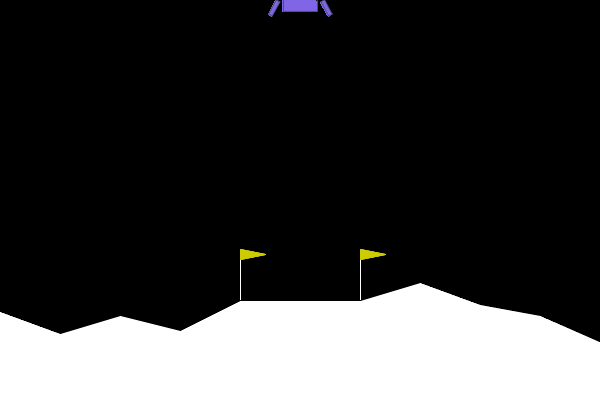

In [8]:
from IPython.display import Image

Image(filename='lunarlander.gif')
